In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import math
import matplotlib.image as image

from keras.models import model_from_json
from skimage.transform import resize
from skimage import color

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename):
    
    print(f'[INFO] Loading file: {filename} ...')
    
    dcm = pydicom.dcmread(filename)       

    age = int(dcm.PatientAge)
    if age < 2 or age > 90:
        print(f'[INFO] Image {filename} rejected, due to the Age: {age}')
        print('\n')
        return None
    
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST', 'chest']:
        print(f'[INFO] Image {filename} rejected, due to the Body part: {body_part}')
        print('\n')
        return None
    
    # Patient Position
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'[INFO] Image {filename} rejected, due to the Patient position: {pos}')
        print('\n')
        return None
    
    mod = dcm.Modality                            
    if mod != 'DX':
        print(f'[INFO] Image {filename} rejected, due to the Modality: {mod}')
        print('\n')
        return None
    
    return dcm.pixel_array
    
def preprocess_image(img, img_mean, img_std, img_size): 
    
    print(f'[INFO] Image processed ...')
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
        
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)
    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = (proc_img - img_mean) / img_std
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    
    return proc_img

def load_model(model_path, weight_path):
    with open(model_path, 'r') as json_file:
        model_file = json_file.read()
        model = keras.models.model_from_json(model_file)
        model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh, filename): 
    
    if model.predict(img)>thresh:
        print(f'[INFERENCE] Patient in {filename} has Pneumonia.')
        print('\n')
        return model.predict(img)>thresh
    else:
        print(f'[INFERENCE] Patient in {filename} has not Pneumonia.')
        print('\n')
        return model.predict(img)>thresh

In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'

# VGG16
IMG_SIZE=(1,224,224,3)  

# Mean & std passed from outside not used
# Resize function used in preprocessing normalizes the image data automatically 

my_model = load_model(model_path, weight_path) 
thresh = 0.4                                   

def predict_dicom(filename):
    
    img = check_dicom(filename)
    
    if img is None:
        return None
    
    
    img_mean = np.mean(img)
    img_std = np.std(img)
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh,filename)
    return pred

[INFO] Loading file: test1.dcm ...
[INFO] Image processed ...
[INFERENCE] Patient in test1.dcm has Pneumonia.


[INFO] Loading file: test2.dcm ...
[INFO] Image processed ...
[INFERENCE] Patient in test2.dcm has Pneumonia.


[INFO] Loading file: test3.dcm ...
[INFO] Image processed ...
[INFERENCE] Patient in test3.dcm has Pneumonia.


[INFO] Loading file: test4.dcm ...
[INFO] Image test4.dcm rejected, due to the Body part: RIBCAGE


[INFO] Loading file: test5.dcm ...
[INFO] Image test5.dcm rejected, due to the Modality: CT


[INFO] Loading file: test6.dcm ...
[INFO] Image test6.dcm rejected, due to the Patient position: XX




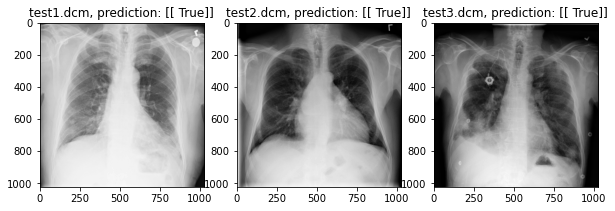

In [4]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
    
for i,filename in enumerate(test_dicoms):
    pred = predict_dicom(filename)
    if pred == None:
        continue
    
    img = pydicom.dcmread(filename).pixel_array        
    
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')

plt.show()